# Predicción del número de aprobados en la PAU en Canarias, con Machine. Learning

### 1. CARGAR LIBRERÍAS.

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from google.colab import files

# Opcional: estilo y display
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [119]:
from google.colab import files

# Subir archivo de predicciones ya generadas
uploaded = files.upload()

# Leer CSV con predicciones
df_resultado = pd.read_csv(next(iter(uploaded)))

# Limpiar nombres de columnas por si acaso
df_resultado.columns = df_resultado.columns.str.strip()

# Verificar que existen las columnas que necesitas
print("🧩 Columnas disponibles:")
print(df_resultado.columns.tolist())

Saving datasets-ISTAC_E30405A_000042_1.0_20250530095746.csv to datasets-ISTAC_E30405A_000042_1.0_20250530095746.csv
🧩 Columnas disponibles:
['TIME_PERIOD#es', 'TIME_PERIOD_CODE', 'UNIVERSIDADES#es', 'UNIVERSIDADES_CODE', 'SEXO#es', 'SEXO_CODE', 'PROCEDIMIENTO_ACCESO#es', 'PROCEDIMIENTO_ACCESO_CODE', 'CONVOCATORIA#es', 'CONVOCATORIA_CODE', 'MEDIDAS#es', 'MEDIDAS_CODE', 'OBS_VALUE', 'CONFIDENCIALIDAD_OBSERVACION#es', 'ESTADO_OBSERVACION#es', 'ESTADO_OBSERVACION_CODE', 'NOTAS_OBSERVACION#es']


### 2. FILTRADO Y PIVOTADO DE LOS DATOS

In [120]:
# Filtrar solo las filas que contienen las medidas relevantes que queremos analizar
df = df[df['MEDIDAS#es'].isin(['Matriculados', 'Presentados', 'Aprobados'])]

# Pivotar la tabla para convertir las medidas en columnas
# Cada combinación única de Año, Sexo, Tipo de Acceso y Convocatoria será una fila
# Las columnas serán: Matriculados, Presentados y Aprobados (extraídas de OBS_VALUE)
df_pivot = df.pivot_table(
    index=['TIME_PERIOD#es', 'SEXO#es', 'PROCEDIMIENTO_ACCESO#es', 'CONVOCATORIA#es'],
    columns='MEDIDAS#es',
    values='OBS_VALUE'
).reset_index()

# Quitar nombre del índice de columnas (por limpieza estética)
df_pivot.columns.name = None

# Renombrar columnas a nombres más simples y comprensibles
df_pivot = df_pivot.rename(columns={
    'TIME_PERIOD#es': 'Año',
    'SEXO#es': 'Sexo',
    'PROCEDIMIENTO_ACCESO#es': 'Acceso',
    'CONVOCATORIA#es': 'Convocatoria'
})

# Eliminar filas con datos incompletos (NaN), para evitar errores más adelante
df_pivot.dropna(inplace=True)

### 3. ANÁLISIS EXPLORATORIO

In [121]:
# 1. Mostrar las dimensiones del DataFrame (número de filas y columnas)
print("Dimensiones del dataset:", df_pivot.shape)

# Mostrar los tipos de datos de cada columna
print("\nTipos de datos:\n", df_pivot.dtypes)

Dimensiones del dataset: (360, 7)

Tipos de datos:
 Año               int64
Sexo             object
Acceso           object
Convocatoria     object
Aprobados       float64
Matriculados    float64
Presentados     float64
dtype: object


In [122]:
# 2. Mostrar los valores únicos por cada variable categórica
# Esto sirve para entender cuántas categorías distintas hay en cada columna de texto
print("\nValores únicos por columna:")
for col in ['Año', 'Sexo', 'Acceso', 'Convocatoria']:
    print(f"{col}: {df_pivot[col].unique()}")


Valores únicos por columna:
Año: [2015 2016 2017 2018 2019 2020 2021 2022]
Sexo: ['Hombres' 'Mujeres' 'Total']
Acceso: ['Prueba de acceso para mayores de 25 años'
 'Prueba de acceso para mayores de 40 años con experiencia laboral'
 'Prueba de acceso para mayores de 45 años'
 'Pruebas de acceso genérica (PAU genérica)' 'Total']
Convocatoria: ['Extraordinaria' 'Ordinaria' 'Total']


In [123]:
# 3. Comprobar si hay valores nulos por columna
# Importante para saber si necesitamos limpieza adicional
print("\nValores nulos por columna:")
print(df_pivot.isnull().sum())


Valores nulos por columna:
Año             0
Sexo            0
Acceso          0
Convocatoria    0
Aprobados       0
Matriculados    0
Presentados     0
dtype: int64


In [124]:
# 4. Mostrar estadísticas descriptivas básicas para las columnas numéricas
# Nos da información como media, desviación estándar, percentiles, etc.
print("\nEstadísticas básicas:")
print(df_pivot[['Matriculados', 'Presentados', 'Aprobados']].describe())


Estadísticas básicas:
       Matriculados  Presentados    Aprobados
count    360.000000   360.000000   360.000000
mean    1528.602778  1460.528704  1330.206481
std     2426.977297  2363.891445  2187.527996
min        0.000000     0.000000     0.000000
25%        9.333333     9.333333     8.500000
50%      187.333333    99.333333    58.333333
75%     2830.833333  2702.666667  2542.333333
max     9360.000000  8918.000000  7914.666667


In [125]:
# 5. Calcular la correlación entre variables numéricas
# Útil para ver qué variables están fuertemente relacionadas
print("\nCorrelación entre variables numéricas:")
print(df_pivot[['Matriculados', 'Presentados', 'Aprobados']].corr())


Correlación entre variables numéricas:
              Matriculados  Presentados  Aprobados
Matriculados      1.000000     0.999669   0.998449
Presentados       0.999669     1.000000   0.999203
Aprobados         0.998449     0.999203   1.000000


In [126]:
# 6. Limpieza de datos categóricos.

# Eliminar filas donde alguna de las columnas categóricas contenga el valor 'Total'
# Esto evita incluir registros que son totales agregados y podrían distorsionar el análisis o el modelo
df_pivot = df_pivot[
    (df_pivot['Sexo'] != 'Total') &
    (df_pivot['Acceso'] != 'Total') &
    (df_pivot['Convocatoria'] != 'Total')
]

# Confirmar que los valores únicos ahora son solo las categorías reales y no incluyen 'Total'
print("Valores únicos después del filtrado:")
print("Sexo:", df_pivot['Sexo'].unique())
print("Acceso:", df_pivot['Acceso'].unique())
print("Convocatoria:", df_pivot['Convocatoria'].unique())

# Verificar las nuevas dimensiones del dataset después del filtrado
print("\nNuevas dimensiones del dataset:", df_pivot.shape)


Valores únicos después del filtrado:
Sexo: ['Hombres' 'Mujeres']
Acceso: ['Prueba de acceso para mayores de 25 años'
 'Prueba de acceso para mayores de 40 años con experiencia laboral'
 'Prueba de acceso para mayores de 45 años'
 'Pruebas de acceso genérica (PAU genérica)']
Convocatoria: ['Extraordinaria' 'Ordinaria']

Nuevas dimensiones del dataset: (128, 7)


### 4. PREDICCIONES SOBRE ESCENARIOS FUTUROS (2025)


In [127]:
# SIMULACIÓN DE ESCENARIOS VARIADOS

# Copia de trabajo
combinaciones_2025_sim = combinaciones_2025.copy()

# Base: 2000 matriculados, 1900 presentados
combinaciones_2025_sim['Matriculados'] = 2000
combinaciones_2025_sim['Presentados'] = 1900

# Ejemplos de personalización:

# Mujeres tienen 100 más presentados que hombres
combinaciones_2025_sim.loc[combinaciones_2025_sim['Sexo'] == 'Mujeres', 'Presentados'] += 100

# Acceso mayores de 45 años tiene menos participación
combinaciones_2025_sim.loc[
    combinaciones_2025_sim['Acceso'] == 'Prueba de acceso para mayores de 45 años',
    ['Matriculados', 'Presentados']
] = [500, 450]

# Convocatoria extraordinaria tiene menor asistencia
combinaciones_2025_sim.loc[
    combinaciones_2025_sim['Convocatoria'] == 'Extraordinaria',
    'Presentados'
] -= 200

# Mostrar tabla modificada
combinaciones_2025_sim.head()

,Año,Sexo,Acceso,Convocatoria,Matriculados,Presentados
0,2025,Hombres,Prueba de acceso para mayores de 25 años,Ordinaria,2000,1900
1,2025,Hombres,Prueba de acceso para mayores de 25 años,Extraordinaria,2000,1700
2,2025,Hombres,Prueba de acceso para mayores de 40 años con e...,Ordinaria,2000,1900
3,2025,Hombres,Prueba de acceso para mayores de 40 años con e...,Extraordinaria,2000,1700
4,2025,Hombres,Prueba de acceso para mayores de 45 años,Ordinaria,500,450


### 4. PREPROCESAMIENTO Y PREPACIÓN DE LOS DATOS

In [128]:
# Codificar y preparar datos como antes
df_model = df_pivot.copy()
df_encoded = pd.get_dummies(df_model, columns=['Sexo', 'Acceso', 'Convocatoria'], drop_first=True)

X = df_encoded.drop(['Aprobados'], axis=1)
y = df_encoded['Aprobados']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 5. ENTRENAMIENTO DEL MODELO

In [129]:
# ENTRENAR EL MODELO
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

### 6. EVALUACIÓN DEL MODELO

In [130]:
# Hacer predicciones con el conjunto de test
y_pred = model.predict(X_test)

# Calcular el Error Medio Absoluto (MAE)
# Indica, en promedio, cuánto se desvía la predicción del valor real
mae = mean_absolute_error(y_test, y_pred)

# Calcular el Error Cuadrático Medio (MSE)
# Penaliza más los errores grandes, útil para comparar modelos
mse = mean_squared_error(y_test, y_pred)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
# Es el MSE en la misma escala que los datos, más interpretable
rmse = np.sqrt(mse)

# Calcular el Coeficiente de Determinación R²
# Indica qué proporción de la varianza de y está explicada por el modelo (1 = perfecto)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados de la evaluación
print("Evaluación del modelo de regresión:")
print(f"MAE   (Error medio absoluto):         {mae:.2f}")
print(f"MSE   (Error cuadrático medio):       {mse:.2f}")
print(f"RMSE  (Raíz del error cuadrático):    {rmse:.2f}")
print(f"R²    (Coef. de determinación R2):    {r2:.4f}")

Evaluación del modelo de regresión:
MAE   (Error medio absoluto):         7.94
MSE   (Error cuadrático medio):       344.05
RMSE  (Raíz del error cuadrático):    18.55
R²    (Coef. de determinación R2):    0.9995


### 7. POST PROCESAMIENTO

In [131]:
# 1. CREAR COMBINACIONES BASE PARA 2025
sexo = ['Hombres', 'Mujeres']
acceso = [
    'Prueba de acceso para mayores de 25 años',
    'Prueba de acceso para mayores de 40 años con experiencia laboral',
    'Prueba de acceso para mayores de 45 años',
    'Pruebas de acceso genérica (PAU genérica)'
]
convocatoria = ['Ordinaria', 'Extraordinaria']

# Crear combinaciones con valores base
combinaciones_2025 = pd.DataFrame([
    {'Año': 2025, 'Sexo': s, 'Acceso': a, 'Convocatoria': c,
     'Matriculados': 2000, 'Presentados': 1900}
    for s in sexo for a in acceso for c in convocatoria
])

# 2. APLICAR SIMULACIONES REALISTAS
combinaciones_2025_sim = combinaciones_2025.copy()

# Mujeres presentan más
combinaciones_2025_sim.loc[combinaciones_2025_sim['Sexo'] == 'Mujeres', 'Presentados'] += 100

# Mayores de 45 años: menor participación
combinaciones_2025_sim.loc[
    combinaciones_2025_sim['Acceso'] == 'Prueba de acceso para mayores de 45 años',
    ['Matriculados', 'Presentados']
] = [500, 450]

# Convocatoria extraordinaria: menor asistencia
combinaciones_2025_sim.loc[
    combinaciones_2025_sim['Convocatoria'] == 'Extraordinaria',
    'Presentados'
] -= 200

### 8. PREDICCIÓN Y VISUALIZACIÓN DEL MODELO

In [132]:
# CODIFICAR Y PREDECIR CON EL MODELO
df_2025_encoded = pd.get_dummies(combinaciones_2025_sim, columns=['Sexo', 'Acceso', 'Convocatoria'])
df_2025_encoded = df_2025_encoded.reindex(columns=X_train.columns, fill_value=0)

# Predecir aprobados
predicciones_2025 = model.predict(df_2025_encoded)
combinaciones_2025_sim['Aprobados_predichos'] = predicciones_2025.round(0).astype(int)

# === 4. MOSTRAR Y EXPORTAR RESULTADOS ===
print("Predicciones 2025 (primeras filas):")
print(combinaciones_2025_sim.head())

# Exportar a CSV
combinaciones_2025_sim.to_csv("predicciones_aprobados_2025.csv", index=False)
files.download("predicciones_aprobados_2025.csv")

Predicciones 2025 (primeras filas):
    Año     Sexo                                             Acceso  \
0  2025  Hombres           Prueba de acceso para mayores de 25 años   
1  2025  Hombres           Prueba de acceso para mayores de 25 años   
2  2025  Hombres  Prueba de acceso para mayores de 40 años con e...   
3  2025  Hombres  Prueba de acceso para mayores de 40 años con e...   
4  2025  Hombres           Prueba de acceso para mayores de 45 años   

     Convocatoria  Matriculados  Presentados  Aprobados_predichos  
0       Ordinaria          2000         1900                 2577  
1  Extraordinaria          2000         1700                 2526  
2       Ordinaria          2000         1900                 2577  
3  Extraordinaria          2000         1700                 2526  
4       Ordinaria           500          450                  377  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [133]:
# Configuración general
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

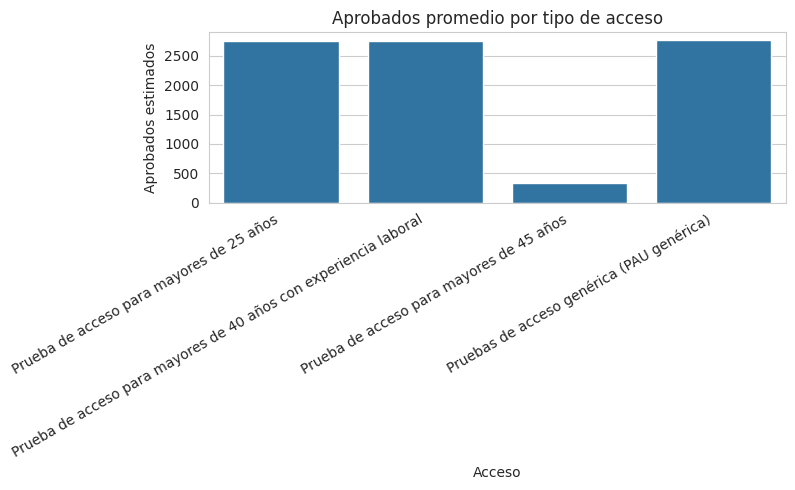

In [134]:
# Aprobados promedio por tipo de acceso
plt.figure()
sns.barplot(
    data=combinaciones_2025_sim,
    x="Acceso",
    y="Aprobados_predichos",
    estimator="mean",
    errorbar=None
)
plt.title("Aprobados promedio por tipo de acceso")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Aprobados estimados")
plt.tight_layout()
plt.show()

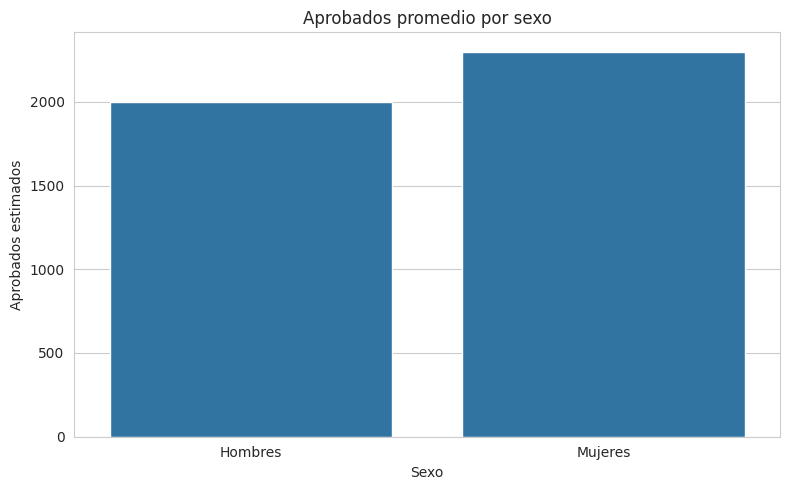

In [135]:
# Aprobados promedio por sexo
plt.figure()
sns.barplot(
    data=combinaciones_2025_sim,
    x="Sexo",
    y="Aprobados_predichos",
    estimator="mean",
    errorbar=None
)
plt.title("Aprobados promedio por sexo")
plt.ylabel("Aprobados estimados")
plt.tight_layout()
plt.show()

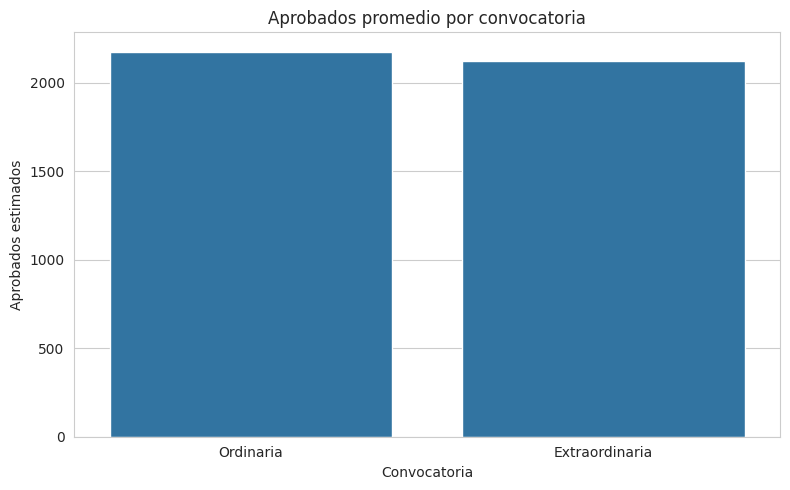

In [136]:
# Aprobados promedio por convocatoria
plt.figure()
sns.barplot(
    data=combinaciones_2025_sim,
    x="Convocatoria",
    y="Aprobados_predichos",
    estimator="mean",
    errorbar=None
)
plt.title("Aprobados promedio por convocatoria")
plt.ylabel("Aprobados estimados")
plt.tight_layout()
plt.show()

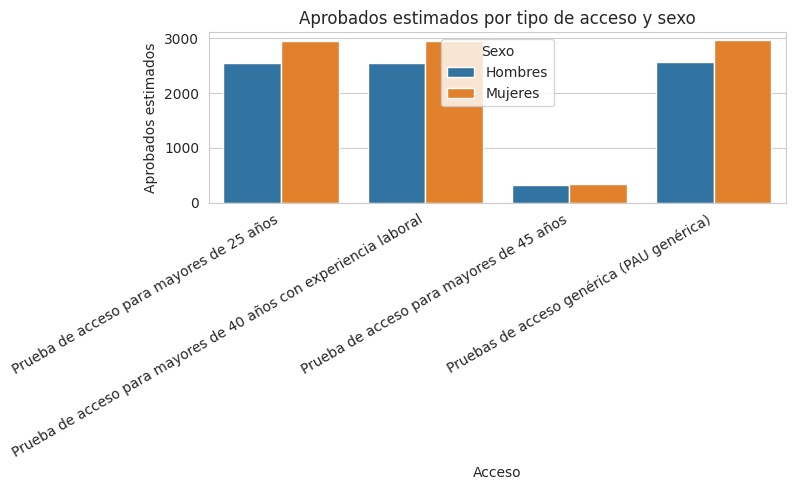

In [137]:
# Aprobados por tipo de acceso y sexo
plt.figure()
sns.barplot(
    data=combinaciones_2025_sim,
    x="Acceso",
    y="Aprobados_predichos",
    hue="Sexo",
    estimator="mean",
    errorbar=None
)
plt.title("Aprobados estimados por tipo de acceso y sexo")
plt.xticks(rotation=30, ha='right')
plt.ylabel("Aprobados estimados")
plt.legend(title="Sexo")
plt.tight_layout()
plt.show()